# Finding Airbnb listings in Copenhagen that are used primarily for renting out using K-means clustering

In [1]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import seaborn as sns
from colour import Color


from IPython.display import HTML, display
import pandas as pd
import numpy as np

from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets
from IPython.display import Markdown
from ipywidgets import Layout

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime as dt
import sklearn
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn import preprocessing

from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, FactorRange, CDSView, Label, LabelSet, Range1d
from bokeh.palettes import GnBu3, OrRd3,Spectral6, RdBu3
from bokeh.plotting import figure, show,  output_file
output_notebook()

import os
import random
import folium

from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

from IPython.display import Image
from IPython.core.display import HTML


df = pd.read_csv('listingsCPH.csv',low_memory=False)
df['host_since'] = pd.to_datetime(df['host_since'])

Loading BokehJS ...

## Problem statement

**This project aims to determine which listings on Airbnb in Copenhagen that is primarily used for renting out and thus not used as permanent housing. Addtionally the goal is to interpret the different characteristics of these types of listings and visualise the entire process.**

To achieve this the following approach is used:   
Step 1: Explore the data to determine which attributes are most relevant for solving the problem statement.   
Step 2: Apply unsupervised clustering to determine which listings that are primarily used for renting out.   
Step 3: Use domain knowledge and the results of the unsupervised clustering to identify personas and use these to illustrate the different listing types.   
Step 4: Communicate the results obtained using a website aimed at the end user being a person with no specific data analysis knowledge.   

# 1. Motivation 
In this chapter, the reasons behind working with this topic are explained and the data used is briefly described. Furthermore, the goals of the visualisation and the end-user experience are described. This section contains:   

- 1.1 Introduction
- 1.2 The data
- 1.3 Visualisation and user experience

### 1.1 Introduction

A trend of sharing economy has arisen, because of the image of being climate-friendly and at the same time earn money on unused resources, [[Sharing Economy is the new black](http://www.businesspower.dk/deleoekonomi-nye-sort/)]. At the same time, Copenhagen has shortages of housing, which leed to the question if some apartments are used as "hotels" rather than for housing citizen,
[[Lack of housing in Copenhagen](https://www.berlingske.dk/danmark/stor-mangel-paa-boliger-foer-studiestart)]. 

On April 4, 2019, the Danish parliament voted on new law regarding home-sharing which is now passed, [[responsible hosting in Denmark](https://www.airbnb.ca/help/article/1382/responsible-hosting-in-denmark?_set_bev_on_new_domain=1586096803_kQkMaj8/azaxEBxq&locale=en)]. With this new regulation, homes can earn up to 28.000 DKK tax-free a year. For summerhouses, this is up to 40.000DKK, [[Denmark approves forward-thinking home-sharing rules and simplifies tax](https://news.airbnb.com/denmark-approves-forward-thinking-home-sharing-rules-and-simplifies-tax/)].   

These new regulations make it possible for private households to rent our their primary home up to 70 days, on the condition that they use a platform that collaborates with the government, such as Airbnb. Airbnb has agreed with the Danish Tax Authority to ensure hosts on Airbnb gets the benefit of the new regulations.  In return, Airbnb shares earning data with the Danish Tax Authorities, [[Denmark approves forward-thinking home-sharing rules and simplifies tax](https://news.airbnb.com/denmark-approves-forward-thinking-home-sharing-rules-and-simplifies-tax/)].  
    
These new regulations make it easier for Airbnb users who rents out their primary home occasionally but also makes life difficult for those who rent out a place for business purposes. Combined this with the lack of affordable housing in Copenhagen, this makes it interesting to investigate how many listings are used primarily for renting out.




### 1.2 The data

The dataset is obtained from insideairbnb.com [[insideairbnb]](http://insideairbnb.com/get-the-data.html), where there is data for a larger number of European cities. The data is updated once each month and is scraped from the Airbnb platform for each listing and host for the given city. This means that all the data is publicly available and can be manually located by simply visiting [[airbnb.dk](http://airbnb.dk)]. In this project, the focus is on Listings in Copenhagen.

There are 3 main data files for each city: 
- **Calendar data:** Contains information about which dates a given listing is available at the time of the scrape. If a listing is not available, it is not possible to see whether the listing is booked or the host has set it unavailable. 
- **Review data:** This data contains review data for each listing.
- **Listings data:** This data contain all information about the listings, including some aggregated measures from the calendar and review data. The two most important aggregated measures are the number of available days the next 365 days (anchored at the scraped date) and the number of reviews per month. 

In this project, the Listings data set is used, since this provides 
sufficient information about the listings and essential information about calendar and review data for this application. 
The chosen dataset was scraped on 29/02/2020 and is called *listings.csv.gz*. This dataset provides information about listing in Copenhagen only. This particular scrape date was chosen since it was just before the Covid-19 restriction started to affect the behaviour of the danish people. Still, the scrape date is recent enough to provide an image of the normal situation. 

The dataset contains of 28.418 rows (listings) and 116 attributes. The attributes are shown in the following list:

In [2]:
# Print all the attributes, to get an overview. 
X = []  

for row in df:
    print(row)
    X.append(row)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

### 1.3 Visualisation end user experience

The goal is to create a webpage, that is author-driven with some elements of interactivity, meaning that the problem statement is told with a clear narrative. The following three key elements are taking into account. [[explanatory data visualization](https://www.youtube.com/watch?v=yHKYMGwefso)]

1. **A question (what results and which stories to tell?)**   
Clear outline of the problem statement.


2. **Allow exploration:**
 - _Overview:_ Make visualisations that give the reader a quick overview of the situation that are investigated. 
 - _Zoom and filter:_ Make it possible to zoom and filter when this creates value for the reader. 
 - _Details on demand:_ Make relevant visualisations interactive. This allows the reader to obtain more information about the parts they find interesting.      
     

3. **Design for an audience (know your readers)**   
The audience is a person with no particular data analysis knowledge. Minor knowledge about the most well known neighbourhoods in Copenhagen is advisable.   

# 2. Basic stats

The purpose of this chapter is to explore the data. This is done by cleaning and filtering the data and finding aspects of the data to dive deeper into in the context of the problem statement. This chapter contains the sections:

- 2.1 Data cleaning and preprocessing
- 2.2 Exploratory data analysis and filtering
     - 2.2.1 Property type
     - 2.2.2 Prices of listings
     - 2.2.3 Location of listings
     - 2.2.4 New Hosts
     - 2.2.5 Measure of activeness of listing

### 2.1 Data cleaning and preprocessing

The dataset has sufficient amount of data and the data has an overall good quality. There are some null values that will be identified and processed during the analysis. 

The neighbourhood names are corrected.

In [3]:
df.loc[df['neighbourhood_cleansed'] == 'Nrrebro', 'neighbourhood_cleansed'] = 'Nørrebro'
df.loc[df['neighbourhood_cleansed'] == 'sterbro', 'neighbourhood_cleansed'] = 'Østerbro'
df.loc[df['neighbourhood_cleansed'] == 'Amager st', 'neighbourhood_cleansed'] = 'Amager Øst'
df.loc[df['neighbourhood_cleansed'] == 'Brnshj-Husum', 'neighbourhood_cleansed'] = 'Brønshøj-Husum'
df.loc[df['neighbourhood_cleansed'] == 'Vanlse', 'neighbourhood_cleansed'] = 'Vanløse'

Below "$" and "," are removed from price. Dates are converted to datetime. In addition, price and neighbourhood_cleansed are updated with the correct data type. 

In [4]:
df['price'] = df['price'].str.replace(r',', '')
df['price'] = df['price'].str.replace(r'$', '')

df['host_since'] = pd.to_datetime(df['host_since'])
df['last_review'] = pd.to_datetime(df['last_review'])
df['calendar_last_scraped'] = pd.to_datetime(df['calendar_last_scraped'])

df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace(r'%', '')

df = df.astype({'price': 'float','neighbourhood_cleansed': 'category'})

Since not all 116 attributes are used, a new dataframe with the used attributes is created and named *dfc*. It is important to note that the removed attributes have been explored, but the following are deemed most interesting in the context of the problem statement. 

In [5]:
# Only take relevant attributes for this analysis. Add if neccessary 
dfc = pd.DataFrame (df, columns = ['last_review', 
                                   'neighbourhood_cleansed', 
                                   'host_name',
                                   'availability_365',
                                   'host_url',
                                   'listing_url',
                                   'latitude', 
                                   'longitude',
                                   'host_picture_url',
                                   'host_id',
                                   'id',
                                   'host_total_listings_count',
                                   'price', 
                                   'host_since',
                                   'room_type', 
                                   'maximum_nights',
                                   'minimum_nights',
                                   'calendar_last_scraped',
                                   'accommodates',
                                   'host_acceptance_rate',
                                   'reviews_per_month'
                                  ])

### 2.2 Exploratory data analysis and filtering

In this section basic plots are shown to find aspects to dive deeper into in the context of the problem statement. Along with this, different cleaning and preprocess choices will be considered.  

#### 2.2.1 Property type

To see which types of property types are actually listed on Airbnb in Copenhagen, a stacked bar chart is plotted below.

In [6]:
# The total sum af property types. 
Sum_P = len(dfc['room_type'])
Enti = len(dfc[(dfc['room_type'] == 'Entire home/apt')])
Priv = len(dfc[(dfc['room_type'] == 'Private room')])
Sha = len(dfc[(dfc['room_type'] == 'Shared room')])
hot = len(dfc[(dfc['room_type'] == 'Hotel room')])


# Create the right dataframe for this plot
dHomes = pd.DataFrame({'Propertytype': 'Property type',
                       'Entire Homes': (Enti/Sum_P)*100,
                        'Private Rooms': (Priv/ Sum_P)*100,
                       'Hotel Rooms': (hot/Sum_P)*100, 
                        'Shared Rooms': (Sha/Sum_P)*100}, index=[0])

In [7]:
#colors = ["#CAF1DE", "#E1F8DC","#FFE7C7", '#D3D3D3']    
colors = ["#5177F9", "#249605","#E83E0C", '#F4B22D']    

Cat =["Entire Homes","Private Rooms", "Shared Rooms", 'Hotel Rooms']

Propertytype = dHomes["Propertytype"]

x_label = "% of host listings" 

sourceDh = ColumnDataSource(dHomes)

In [8]:
pHomes = figure(y_range=Propertytype, plot_height=300, plot_width =900, x_axis_label = x_label, title="% of listings by property Type",
           toolbar_location=None, tools="hover", tooltips="$name @$name%")

pHomes.hbar_stack(Cat, y='Propertytype', height=0.8, source=sourceDh, color=colors, 
             legend=[dict(value=["Entire Homes"]),dict(value=["Private Rooms"]), dict(value=["Shared Rooms"]), dict(value=["Hotel Rooms"])])

pHomes.legend.location = "top_left"
pHomes.legend.orientation = "vertical"
pHomes.xgrid.visible = False
pHomes.ygrid.visible = False

#pHomes.add_layout(labels)
show(pHomes) 



As seen in the above plot, the most dominant room type is entire homes followed by private rooms. Shared rooms and hotel rooms cover about 0.4% of the total number of listings.   
As mentioned in the problem statement, the idea of this project is to determine which listings are used primarily for renting out. It is assumed, that if a listing has the property type private or shared room, the host lives in the home and rents out some extra space. These types of listings are not of interest. Hotel rooms are also different from entire homes and are thus not of interest.   
This leaves 'entire homes' to be the scope of this project. The other property types are filtered out of the data below. 

In [9]:
size_beforeProp = len(dfc)
dfc = dfc[(dfc['room_type'] == 'Entire home/apt')]
size_afterProp = len(dfc)
print(str(size_beforeProp-size_afterProp) + " rows are removed, these are hosts with property type private, shared or hotel rooms.")

4492 rows are removed, these are hosts with property type private, shared or hotel rooms.


#### 2.2.2 Prices of listings

The price per night (called price for short) is interesting because this is the main driver for renting out and gives a good impression of the Airbnb market in Copenhagen. The prices of different neighbourhoods are shown by using boxplots in the following.

In [10]:
chosen_attributes_price = ['id','price','last_review', 'neighbourhood_cleansed','host_total_listings_count', 'host_name','availability_365','host_url']

Remove na values from the price column of the copy of the data frame if any na's exists.

In [11]:
data_new_hosts_clean = dfc
size_before_Price = len(data_new_hosts_clean)
data_new_hosts_clean = data_new_hosts_clean.dropna(axis=0, subset=['price'])
size_after_Price = len(data_new_hosts_clean)
print(str(size_before_Price-size_after_Price) + " na rows removed from data")

0 na rows removed from data


Define the data that are used for plotting the boxplots

In [12]:
data_price = pd.DataFrame (data_new_hosts_clean, columns = chosen_attributes_price)

Change the datatypes to the correct type

In [13]:
data_price = data_price.astype({'price': 'float','neighbourhood_cleansed': 'category'})

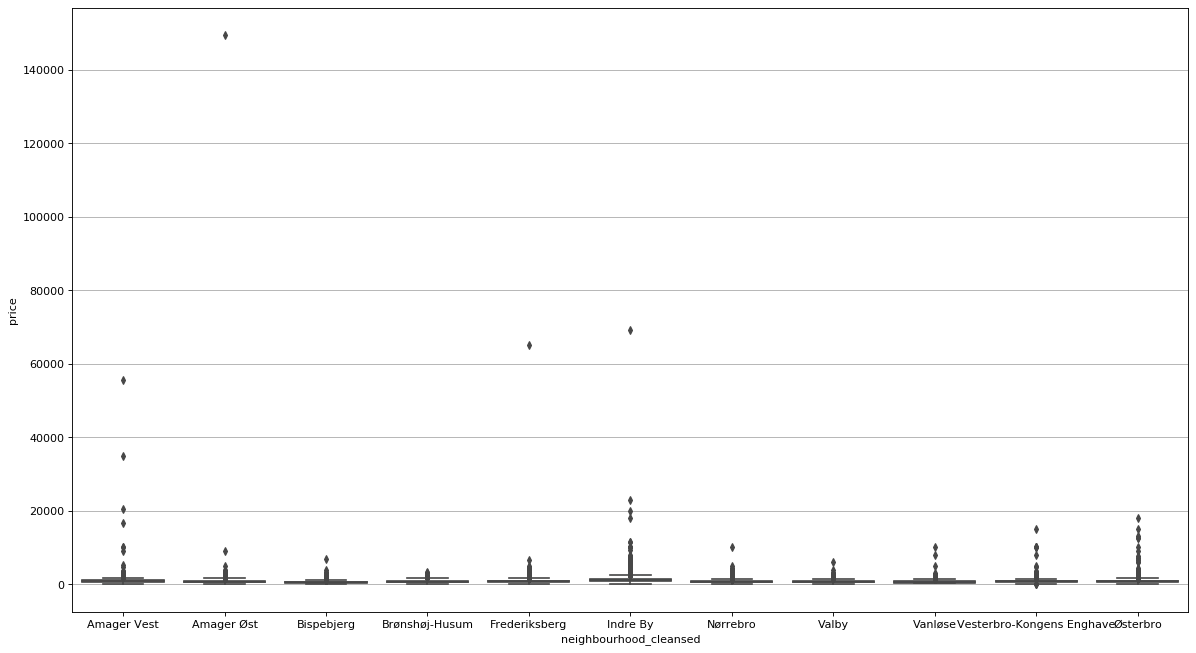

In [14]:
fig =plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.boxplot(x="neighbourhood_cleansed", y="price", data=data_price)
ax.yaxis.grid(True)

In the chart above some outliers are seen, where som listings are very expensive. When looking into these outliers, the listings are either luxury apartments or normal apartments where the price has been increased to what seems like an unrealistic amount for no aparent reason. 

These few listings that are very expensive makes it hard to see the distribution of the prices. A filter is therefore applied below. 

In [15]:
size_before_Price = len(data_price)
condition1 = data_price['price'] <= 5000
data_price_filter = data_price[condition1]
size_after_Price = len(data_price_filter)
print(str(size_before_Price-size_after_Price) + " rows removed from data")

72 rows removed from data


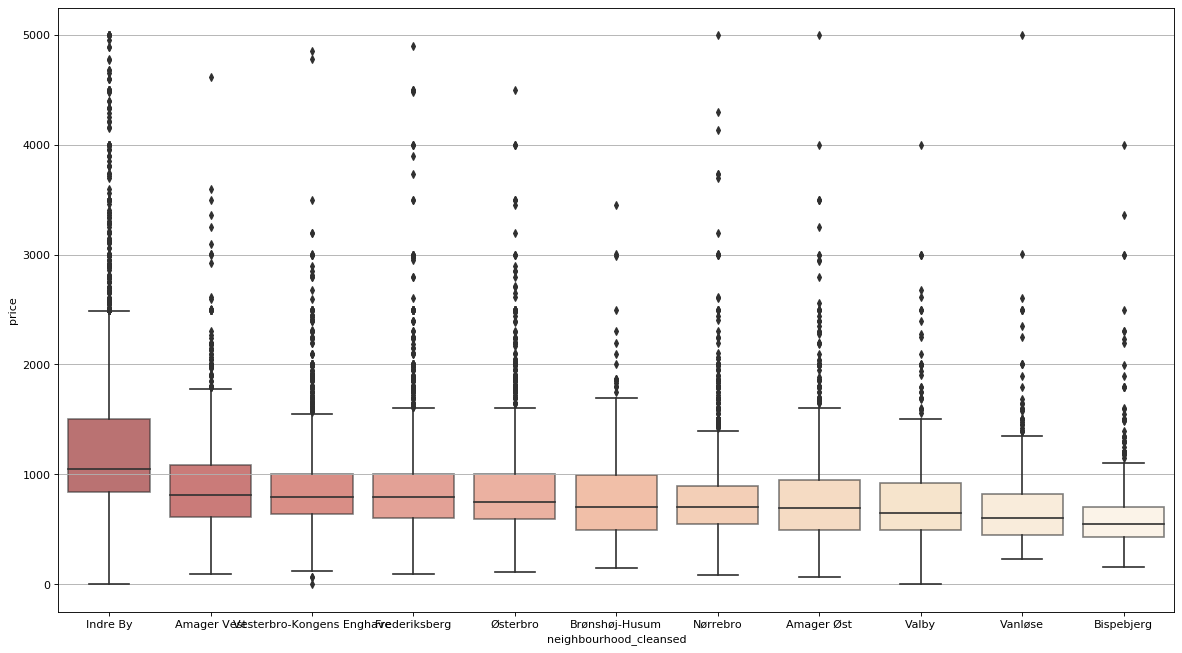

In [16]:
fig =plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')

item_order = data_price_filter.groupby(by=['neighbourhood_cleansed'])['price'].median().sort_values(ascending=False).index

ax = sns.boxplot(x="neighbourhood_cleansed", y="price", 
                 data=data_price_filter, order=item_order,palette="OrRd_r",boxprops=dict(alpha=.6))
ax.yaxis.grid(True)

The boxplots by the median in descending order, which shows that the most expensive neighbourhood is "Indre By" and that prices seem to decrease as the listing moves further away from the city centre - se for example "Vanløse". This is probably due to the fact that tourist are the most frequent users of Airbnb in Copenhagen and prefers to live close to the city center where the main attractions are located. They will therefore be willing to pay a higher price for the location.   

If for instance a student has an appartment in 'Indre By' and rents it out for less than the median price, for 7 nights, this will result in an income larger than the monthly SU (state education grant). 

Since not everybody understands how boxplots and medians work, a bar chart with the mean price per neighbourhood is also plotted specifically for the final visualisation.

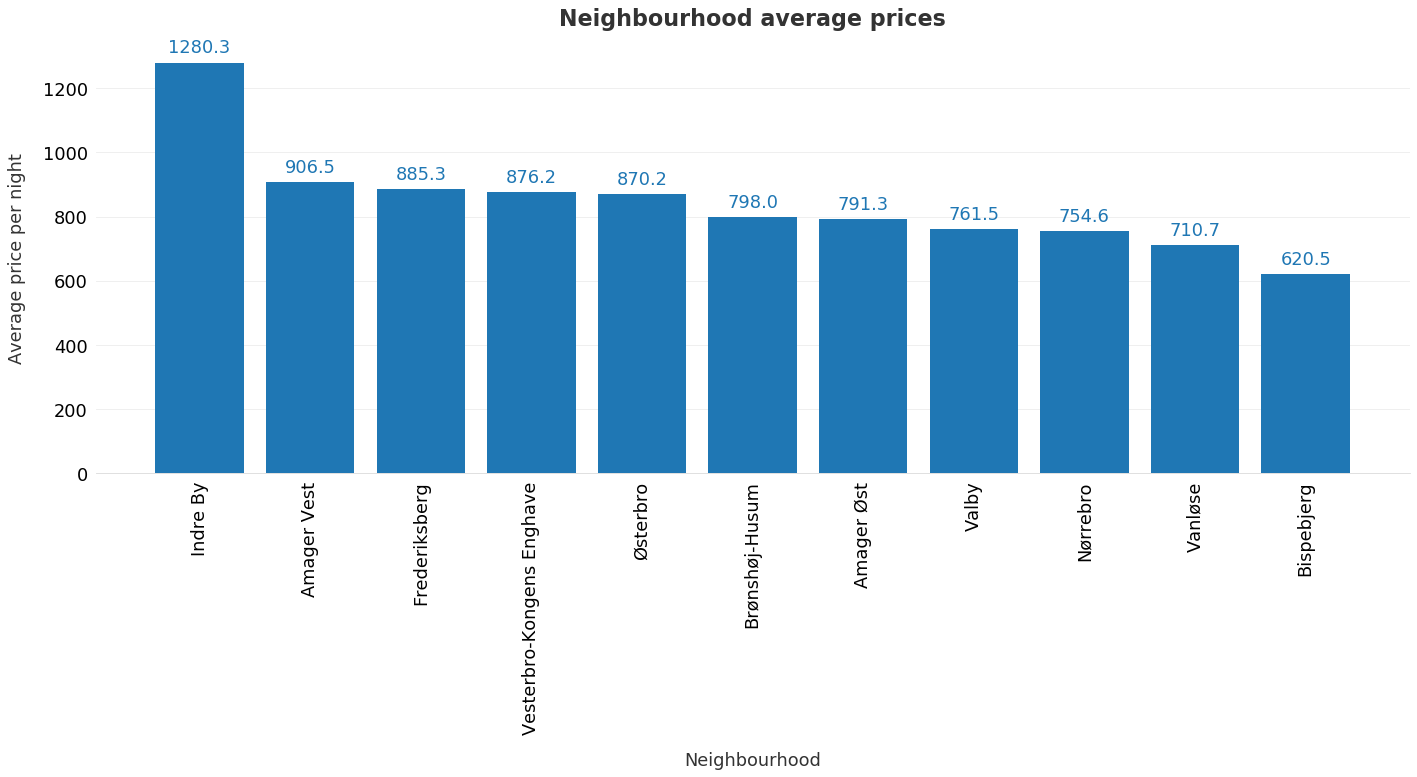

In [17]:
#fig =plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 16})
#df.sort_values(by=['col1', 'col2'])
price_bar = data_price_filter[['price', 'neighbourhood_cleansed']].groupby('neighbourhood_cleansed').mean().sort_values(by=['price'],ascending=False)
# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(price_bar.size),
    height=price_bar['price'],
#    tick_label=price_bar.index.strftime('%Y')
    tick_label=price_bar.index
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                # specify integer or one of preset strings, e.g.
                #tick.label.set_fontsize('x-small') 
                tick.label.set_rotation('vertical')

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 30.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Neighbourhood',fontsize=16, labelpad=15, color='#333333')
ax.set_ylabel('Average price per night',fontsize=16, labelpad=15, color='#333333')
ax.set_title('Neighbourhood average prices',fontsize=20, pad=15, color='#333333',
             weight='bold')
plt.tick_params(labelsize=16);

fig.tight_layout()

#### 2.2.3 Location of listings
To provide a general overview of where most listings on Airbnb in Copenhagen are located, a heat map is generated. 

In [18]:
# If there are any NA's, ignore these
heatdata = dfc.dropna(axis=0, subset=['latitude', 'longitude'])

In [19]:
map_CPHheat = folium.Map(location=[55.672163978, 12.568164394], 
                    zoom_start = 12,
                    tiles = "Stamen Terrain")

# Add a marker
folium.Marker([55.672163978, 12.568164394], popup='Copenhagen City Hall', icon=folium.Icon(color='lightgray', icon='building', prefix='fa')).add_to(map_CPHheat)

# Ensure the datatype is float
heatdata['latitude'] = heatdata['latitude'].astype(float)
heatdata['longitude'] = heatdata['longitude'].astype(float)

# List comprehension to make out list of lists
heatdata = [[row['latitude'],row['longitude']] for index, row in heatdata.iterrows()]

#gradient = {.40: '#F5F5DC', .66: '#ffeeed', 1: 'red'}
gradient = {.3: 'lightgreen', .5: 'yellow',0.7: 'orange', 0.80: 'red', 0.9: 'darkred'}

# Plot on the map
#HeatMap(heatdata, max_opacity=0.8, radius = 7, max_zoom=16, gradient=gradient).add_to(map_CPHheat)
HeatMap(heatdata, max_opacity=0.8, radius = 6.5, max_zoom=17, gradient=gradient).add_to(map_CPHheat)

# Display the map
map_CPHheat

As seen it the heat map above, there are some areas where the listings are more densely located than in other areas. In general, it seems like the number listings decrease as the distance to the city center (defined as city hall, see pin) increases. Except in Østerbro and Nørrebro area, where listings may not be close to city hall, but a located close to attractions such as 'Kastellet' and 'Nørrebro'. Additionally new construction areas in Copenhagen such as Sydhavnen, Islandsbrygge, Ørestad etc. seems to have a dense number of listings, [[new construction areas in Copenhagen](https://propstep.com/da/nybyggerier-i-koebenhavn/)].   

The map also reveals which areas of the city that people live, and which areas are used for other things such as parks (see for instance 'Botanisk Have') and Educational Institutions (see for instance Center for Sundhed og Samfund, CSS just southwest of 'Botanisk Have').


#### 2.2.4 New Hosts
As mentioned in the introduction, the use of sharing economy platforms have been rising within recent years. To see how this development looks for Airbnb in Copenhagen, the year a host signs up for Airbnb is investigated. This also gives an impression of the total number of hosts. To perform this analysis, the raw data is used. This data is illustrated by counting distinct new hosts per year and the running total.   

In [20]:
# Should be host_since and host_id
chosen_attributes_host = ['host_since', 'host_id']

Remove na values from the data frame copy 

In [21]:
data_new_hosts_clean = df
size_before = len(data_new_hosts_clean)
data_new_hosts_clean = data_new_hosts_clean.dropna(axis=0, subset=chosen_attributes_host)
size_after = len(data_new_hosts_clean)
print(str(size_before-size_after) + " na rows removed from data")

9 na rows removed from data


In [22]:
#data_new_hosts_clean.drop_duplicates(subset ="host_id", keep = 'first', inplace = True) 
data_new_hosts_clean = data_new_hosts_clean.drop_duplicates(['host_id']).reset_index(drop=True)

In [23]:
data_new_hosts = pd.DataFrame (data_new_hosts_clean, columns = chosen_attributes_host)

#Add a column with year
data_new_hosts['host_since_year'] = pd.DatetimeIndex(data_new_hosts['host_since']).year

In [24]:
agg_new_hosts = data_new_hosts.groupby(['host_since_year']).count()
agg_new_hosts = agg_new_hosts.iloc[:,0:1]

In [25]:
# Prepare for plotting
host_since_years = agg_new_hosts.index.to_numpy()
host_since_years = np.transpose(host_since_years)

In [26]:
# Prepare for plotting
host_since_count = agg_new_hosts.to_numpy()
l=host_since_count
flatten = lambda l: [item for sublist in l for item in sublist]
host_since_count = flatten(l)

Compute the running total

In [27]:
host_since_running_total = np.cumsum(host_since_count)

Plot the data together

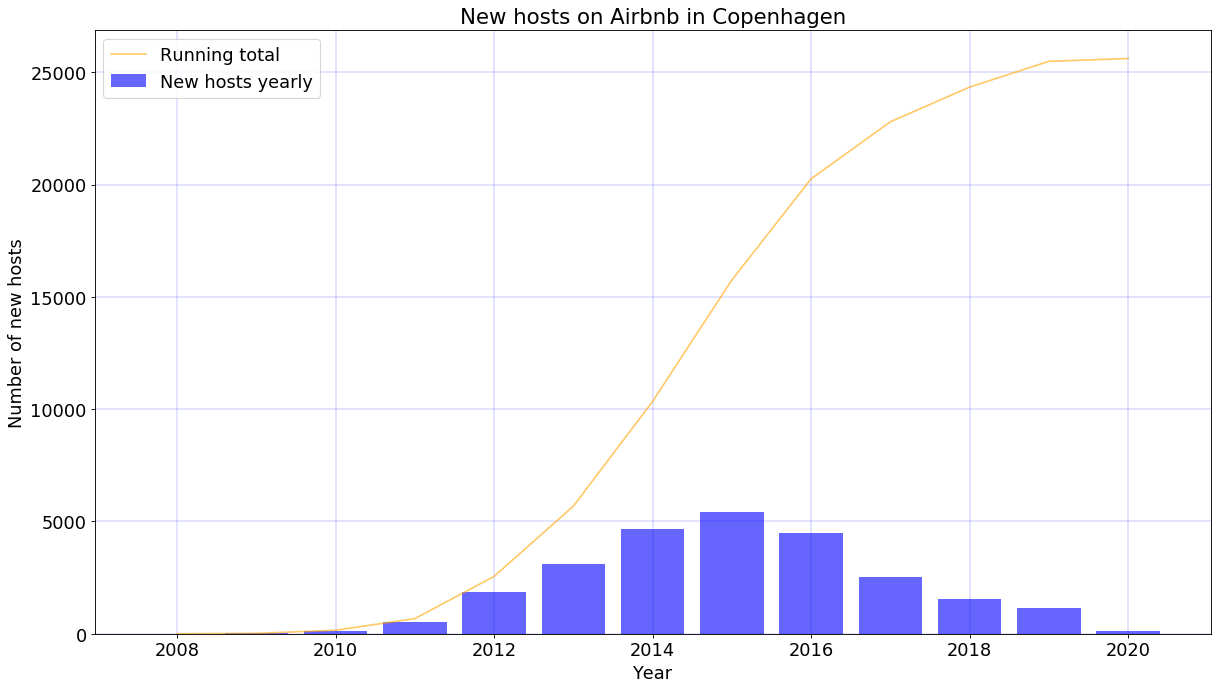

In [28]:
fig =plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.bar(host_since_years,host_since_count, 
            color='blue', label ='New hosts yearly', alpha=0.6)
plt.plot(host_since_years,host_since_running_total, 
            color='orange', label ='Running total', alpha=0.6)

plt.title('New hosts on Airbnb in Copenhagen')
plt.xlabel('Year')
plt.ylabel('Number of new hosts')
plt.legend()

plt.grid(color='b', linestyle='-', linewidth=0.2)

As seen in the above plot, the peak of new hosts was in 2015 and the running total is still increasing as of 2020.   
The interesting aspect of this is whether these hosts are active users of Airbnb, which is explored in the following. 

#### 2.2.5 Measure of activeness of listing

An apparent measure of activeness for a listing is to use the attribute 'reviews_per_months', which is aggregated based on the review data mentioned in chapter 1. Even though not every guest gives a review, it still provides a good relative measure of how often a listing is rented out. 

Another measure of activeness is whether a listing has availability or not. A listing used as a sharing economy listing might still occasionally be active, even though the availability of the next 365 days is zero. A listing used primarily for renting out will most likely have some availability for the next 365 days. Based on this, all listings that have availability the next 365 days equal to zero are removed from the dataset.

Note that if a listing is not available on a given day, it can either mean that a listing is set unavailable by the host or that the listing is booked. This data is not published by Airbnb.   

In [29]:
# Remove listings with availability_365=0
size_beforeProp = len(dfc)
condition_availability = dfc['availability_365'] >= 1
dfc = dfc[condition_availability]
size_afterProp = len(dfc)
print(str(size_beforeProp-size_afterProp) + " rows are removed, because listings have an availability_365 of zero .")

14786 rows are removed, because listings have an availability_365 of zero .


# 3. Data Analysis

The purpose of this section is to determine if a listing is used primarily for renting out (not used as primary housing) or as a sharing economy (used as primary housing). In the remainder of this report the listings used primarily for renting out are called 'Business' and the listings used primarily as housing are called 'Shared'.

Clustering the listings in either 'Business' or 'shared' is done by initially investigating which attributes are relevant in this context and then applying unsupervised clustering (K-means) and interpretation of the generated clusters. This chapter contains the following sections:

- 3.1 Unsupervised clustering to determine business vs. shared
    - 3.1.1 Relevant attributes to include in unsupervised clustering 
    - 3.1.2 Normalise the data
    - 3.1.3 The Elbow method - determine the number of clusters
    - 3.1.4 Visualisation and interpretation of the clusters 
- 3.2 Hosts using Airbnb as a business platform for entire appartmens 

### 3.1 Unsupervised clustering to determine business vs. shared   
The goal of using unsupervised clustering is to discover hidden patterns and to cluster the different listings into groups with similar characteristics. 

The approach is to initially to perform K-means cluster analysis and then manually interpret the clusters by assigning the clusters to either the 'business' or the 'shared' class. In the short term, the k-means clustering minimizes the sum of squared distances to the center of the clusters. A cluster can be seen as a set of data points that are similar and dissimilar to the other clusters. The thing that is important to have in mind when using clustering is that the number of cluster centers (centroids) K, is an input to the algorithm. The value K (number of clusters to be generated) of course influences the solution a lot. It is therefore important to determine the best possible K for the given application. [[Unsupervised learning and data clustering.](https://towardsdatascience.com/unsupervised-learning-and-data-clustering-eeecb78b422a)]. 
For the clustering in this project, the Elbow method is applied to determine K. 

#### 3.1.1  Attributes included in unsupervised clustering

The attributes used as input to the K-means clustering were determined by using domain knowledge.
    
The chosen attributes listed below are the final choice, but other combinations of attributes have been tested.  The below combination yielded the best results regarding interpretability and clarity in dividing the generated cluster into business or shared. The chosen attributes are:   

- **availability_365:** The number of days the listing is available for booking in the next 365 days, measured from the date of the data scrape.
- **reviews_per_month:** The number of reviews per month for the listing.
- **host_total_listings_count:** The number of listings that the host has in total.

In [30]:
chosen_attributes = ['availability_365','reviews_per_month','host_total_listings_count']

Remove na values from a dataframe copy to be able to append the data after clustering. Note that if a listing has no reviews at all, the reviews per month attribute is an na value and will thus be removed in the following cleaning. 

In [31]:
dfc_copy = dfc
size_before = len(dfc_copy)
dfc_copy = dfc.dropna(axis=0, subset=chosen_attributes)
size_after = len(dfc_copy)
print(str(size_before-size_after) + " na rows removed from data_cluster")

1167 na rows removed from data_cluster


In [32]:
# Make sure that the correct dataset is used
if df.last_scraped[0] == '2020-02-29':
    print("Correct dataset is used")
else:
    raise ValueError('The wrong dataset is used. It must be the dataset last scraped at "2020-02-29"')

Correct dataset is used


Define the data to be used for clustering

In [33]:
data_cluster = pd.DataFrame (dfc_copy, columns = chosen_attributes)

In [34]:
#Display a sample of the data, to get an overview. 
data_cluster.head(5)

availability_365  reviews_per_month  host_total_listings_count
1               333               0.66                        1.0
2                81               2.56                        4.0
3                26               0.19                        1.0
6                38               0.63                        4.0
7                70               0.06                        1.0

To get a sense of the distribution of the used attributes, for clustering, histograms and scatter plots are shown below.

In [35]:
data_cluster_hist = data_cluster

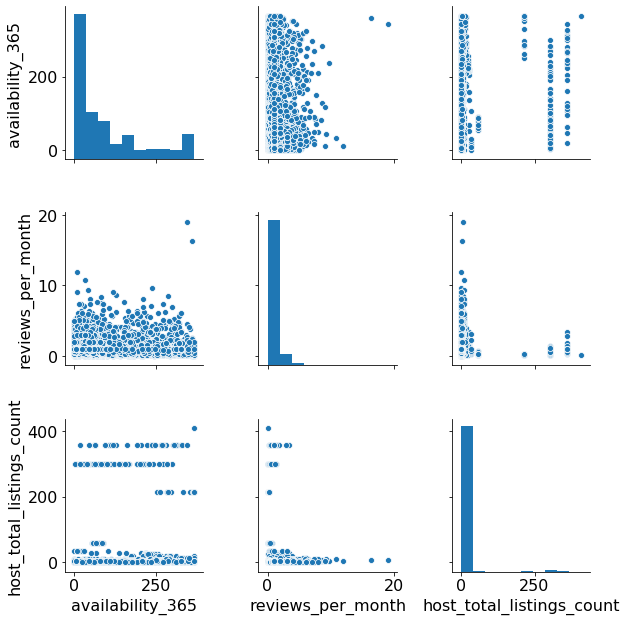

In [36]:
sns.pairplot(data_cluster_hist,height=3)

By looking a the plots vertically for one attribute at a time:   
- **Availability_365:** Most listings are available for less than 100 days.  Whereas the availability above 100 days is evenly distributed except for a peak in the high end of the availability up to one year. 
- **Reviews per month:** Most of the data lie below 3 reviews per month and only a small percentage has more than 5 reviews per month. 
- **Host total listings:** The main part of host listings count lies in the low end and only a few listings have a high number of around 300. These listings will most likely have the same host since the data points reside on a straight vertical line in the top right plot. 

#### 3.1.2 Normalise the data

When applying clustering, it is important to normalise the data. This is done by using the standard scaler, which subtracts the mean and divides by the standard deviation. This ensures, that the clustering will not depend on the units of the data, but on the variability from the mean. 

scale_data = 1: Scale the data   
scale_data = 0: Do not scale the data

In [37]:
scale_data = 1
if scale_data == 1:
    standard_scaler = preprocessing.StandardScaler()
    x_scaled = standard_scaler.fit_transform(data_cluster)
    data_cluster = pd.DataFrame(x_scaled,columns=chosen_attributes)
    
data_cluster.head(5)

availability_365  reviews_per_month  host_total_listings_count
0          2.147320          -0.207069                  -0.140189
1         -0.158111           1.660499                  -0.062026
2         -0.661281          -0.669046                  -0.140189
3         -0.551499          -0.236557                  -0.062026
4         -0.258745          -0.796827                  -0.140189

#### 3.1.3 The Elbow Method - determine the number of clusters   
To determine K, The Elbow Method is used. In this method, the K-means algorithm is executed for a range of specified values of K. For each K value the within cluster sum of squares is calculated. The idea is to find the "elbow" of the corresponding line chart, because this is the point where the gain of increasing the number of K starts to decrease.
[[kmeans elbow method python](https://pythonprogramminglanguage.com/kmeans-elbow-method/)]. 

**INPUT:** How many cluster values to test in the Elbow method

In [38]:
cluster_to_test = 10

Loop through all different K-values and compute the within-cluster sum of squares.

In [39]:
wcss=[]

for i in range (1,cluster_to_test+1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_cluster)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

Plot the results

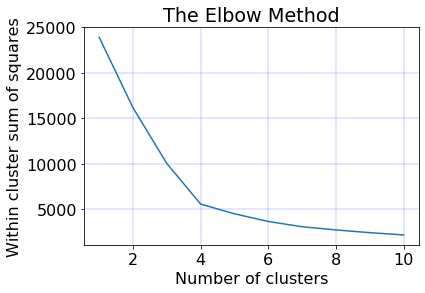

In [40]:
number_clusters = range(1,cluster_to_test+1)
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster sum of squares')

plt.grid(color='b', linestyle='-', linewidth=0.2)

As seen in the above plot, the Elbow of the graph is at K=4. However, when looking at the results for only K=4 clusters, the clusters are difficult to interpret, and the number of clusters is thus increased to K=6 to make the clusters even more detailed. The final number of clusters is thus 6. 

In [41]:
K_clusters = 6

#### 3.1.4 Visualitation and interpretation of the clusters

Fit the clustering model to the assigned number of clusters and add labels to the cluster data. The K-means algorithm results may depend on the initialisation, which is randomised. The parameter n_init is set to 100 to ensure that a good final cluster is obtained.

In [42]:
kmeans = KMeans(n_clusters=K_clusters, random_state=0,n_init=100).fit(data_cluster)

# Scale the data back for visuals
if scale_data == 1:
    x_scaled = standard_scaler.inverse_transform(data_cluster)
    data_cluster = pd.DataFrame(x_scaled,columns=chosen_attributes)
    
data_cluster.head(5)

# Map the generated cluster labels to be sorted by cluster size to make sure same 
# cluster are output no matter which machine algoritm is run on
idx = np.argsort(kmeans.cluster_centers_[:,0])

lut = np.zeros_like(idx)
lut[idx] = np.arange(K_clusters)+1

print('Cluster label mapping:')
print(idx)
print(lut)
# Append the sorted cluster labels
data_cluster['cluster'] = lut[kmeans.labels_]

Cluster label mapping:
[0 3 5 4 2 1]
[1 6 5 2 4 3]


#### Plotting the clusters

One of the challenges in visualising the clusters is that there are more than two dimensions. To get a sense of the different clusters, the attributes 'availability_365' and 'reviews_per_month' is used.

**INPUT:** Choose which two attributes to use to visualise the clusters

In [43]:
x_axis_attr_index = 0
y_axis_attr_index = 1
x_axis_attr = chosen_attributes[x_axis_attr_index]
y_axis_attr = chosen_attributes[y_axis_attr_index]

Plot the clusters

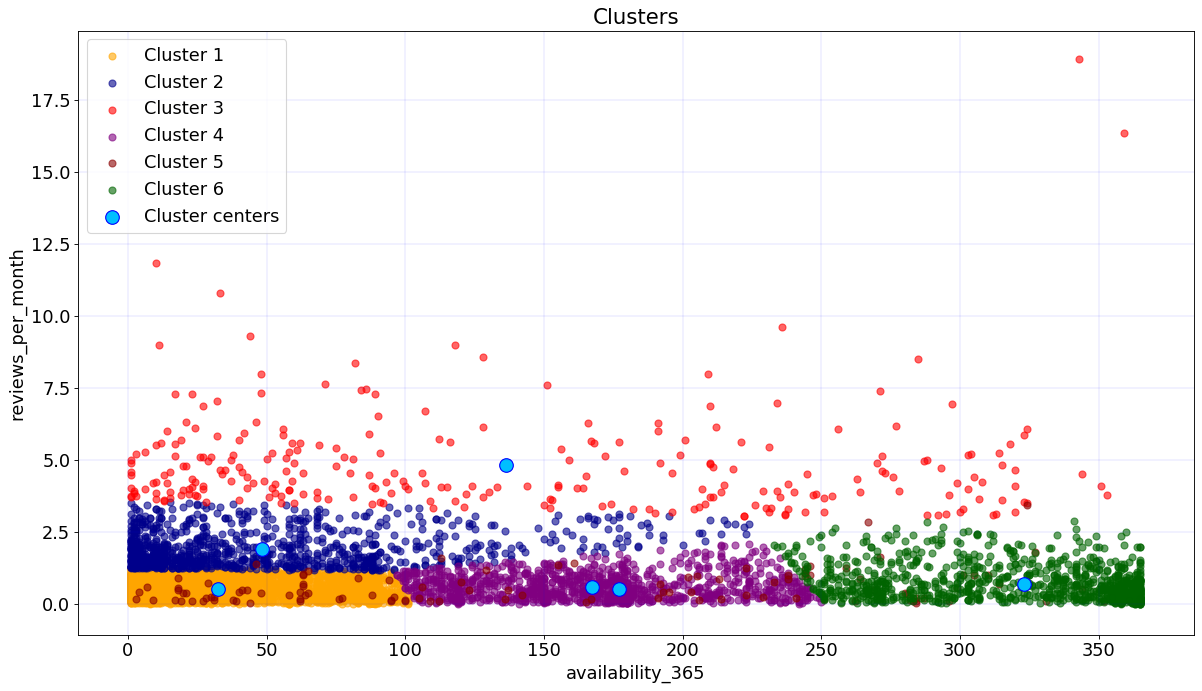

In [44]:
fig =plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')



tableau_colors = ['blue','orange','darkblue','red', 'purple', 'darkred','darkgreen','pink','lightblue','lightgreen','grey']


if scale_data == 1:
    # Scale the cluster centers back
    cluster_centers = standard_scaler.inverse_transform(kmeans.cluster_centers_)

for clus in range(1,K_clusters+1):
    label_cluster = 'Cluster ' + str(clus)

    
    plt.scatter(data_cluster.loc[data_cluster['cluster']==clus,
                x_axis_attr], data_cluster.loc[data_cluster['cluster']==clus,y_axis_attr], 
                s=40, c=tableau_colors[clus], label =label_cluster, alpha=0.6)

plt.scatter(cluster_centers[:,x_axis_attr_index]
            ,cluster_centers[:,y_axis_attr_index], 
            s=150, c='deepskyblue', label ='Cluster centers',marker='o',edgecolors='b')

plt.title('Clusters')
plt.xlabel(x_axis_attr)
plt.ylabel(y_axis_attr)
plt.legend()

plt.grid(color='b', linestyle='-', linewidth=0.1)

As seen in the above plot, the clusters are nicely divided into 6 clusters and the cluster centers are plotted. The pattern of cluster 5 is difficult to see on this plot since it is very spread out across cluster 1,4 and 6. This occurs because the main characteristic of cluster 5 is that it has high values of total host listings. 

The cluster centroids are displayed below. 

In [45]:
cluster_index_name = 'cluster_index'
count_in_cluster_name = 'count_in_cluster'


df_cluster_center = pd.DataFrame({ cluster_index_name : lut})

clusterCount = []
for item in df_cluster_center[cluster_index_name]:
    clusterCount.append(data_cluster.cluster.value_counts()[item])
    
df_cluster_center[count_in_cluster_name] = clusterCount

for num, attr in enumerate(chosen_attributes):
    df_cluster_center[attr] = cluster_centers[:,num]

In [46]:
df_cluster_center.sort_values('availability_365')

cluster_index  count_in_cluster  availability_365  reviews_per_month  \
0              1              4359         32.365221           0.512113   
3              2               992         48.486895           1.920524   
5              3               267        136.344569           4.845131   
4              4              1184        167.278716           0.591132   
2              5               127        177.196850           0.520157   
1              6              1044        323.240421           0.713352   

   host_total_listings_count  
0                   1.523744  
3                   1.253024  
5                   2.707865  
4                   1.647804  
2                 302.354331  
1                   1.834291

Interpretation of the clusters:  
**Cluster 1 - Sharing:**  The listing is the hosts primary home and are occasionally rented out   
**Cluster 2 - Sharing:**  The listing is the hosts primary home and are often rented out     
**Cluster 3 - Business:** Very often rented out and the host has several listings   
**Cluster 4 - Business:** Often rented out      
**Cluster 5 - Business:** Numerous listings. The host uses Airbnb as an established business   
**Cluster 6 - Business:** Available all year and often rented out.

In [47]:
# Define the clusters 
business_clusters = [3,4,5,6]
sharing_clusters = [1,2]

cluster1_name = 'Shared'
cluster2_name = 'Shared'
cluster3_name = 'Business: The Super Host'
cluster4_name = 'Business: The Flexible Host'
cluster5_name = 'Business: The King of the Hosts'
cluster6_name = 'Business: The Very Flexible Host'

data_cluster['cluster_name'] = 'no name given'
data_cluster.loc[(data_cluster.cluster == 1),'cluster_name']=cluster1_name
data_cluster.loc[(data_cluster.cluster == 2),'cluster_name']=cluster2_name
data_cluster.loc[(data_cluster.cluster == 3),'cluster_name']=cluster3_name
data_cluster.loc[(data_cluster.cluster == 4),'cluster_name']=cluster4_name
data_cluster.loc[(data_cluster.cluster == 5),'cluster_name']=cluster5_name
data_cluster.loc[(data_cluster.cluster == 6),'cluster_name']=cluster6_name

In [48]:
#Add the interpretation to the cluster data
data_cluster['Business'] = 'not classified'
data_cluster['Sharing'] = 'not classified'
data_cluster.loc[(data_cluster.cluster.isin(business_clusters)),'Business']='1'
data_cluster.loc[(data_cluster.cluster.isin(sharing_clusters)),'Business']='0'
data_cluster.loc[(data_cluster.cluster.isin(business_clusters)),'Sharing']='0'
data_cluster.loc[(data_cluster.cluster.isin(sharing_clusters)),'Sharing']='1'

Join the clusters with the data 

In [49]:
dfc_with_clusters = pd.concat([dfc_copy.reset_index(drop=True),data_cluster.reset_index(drop=True)], axis=1)

# Remove duplicate rows created in the join
dfc_with_clusters = dfc_with_clusters.loc[:,~dfc_with_clusters.columns.duplicated()]

### 3.2 Hosts using Airbnb as a business platform for entire appartmens 

Chapter 3 will investigate hosts that are using Airbnb as a business platform for entire apartments. The categorization of hosts corresponding to business is based on the above clustering analysis.  
The structure of chapter 3.2 is: 
- 3.2.1 The overall distribution of business vs. shared economy.  
- 3.2.2 Interactive investigation of hosts that are categorized as business   
- 3.2.3  Personas for clusters that are categorized as business


#### 3.2.1 The overall distribution of business vs. shared economy 

In [50]:
b_vs_s = dfc_with_clusters['Business'].value_counts()

print("Number of listings in 'Shared' cluster: "+str(b_vs_s[0]))
print("Number of listings in 'Business' cluster: "+str(b_vs_s[1]))

Number of listings in 'Shared' cluster: 5351
Number of listings in 'Business' cluster: 2622


#### 3.2.2 Interactive investigation of hosts that are categorized as business

To look deeper into the different clusters and the persons behind them, the clusters are initially plotted on a geographic map that allows to chose which cluster to view in the plot.

Set the clusters to be displayed in the map:

In [51]:
show_me = [3,4,5,6]

In [52]:
# Get data to map
mapData_clusters = dfc_with_clusters

#mapData_clusters = mapData_clusters[condition1]
mapData_clusters = mapData_clusters[mapData_clusters['cluster'].isin(show_me)]

###########################################################
# Start doing map stuff
###########################################################
map_CPH_clusters = folium.Map(location=[55.672163978, 12.568164394], 
                    zoom_start = 12,
                    tiles = "Stamen Terrain")

# Define which attribute to color the datapoints in the plot
gradient_attribute = 'cluster'

for ind in mapData_clusters.index: 
    # Calculate the marker color
    color_index = mapData_clusters[gradient_attribute][ind]
    cluster_color = tableau_colors[color_index]

    # Pop-ups
    url_listing = mapData_clusters['listing_url'][ind]
    url_host = mapData_clusters['host_url'][ind]
    html_host_img = """<img src="%s " height="120" width="120"/>""" % mapData_clusters['host_picture_url'][ind]

    # Markers
    folium.CircleMarker(
        location=[mapData_clusters['latitude'][ind], mapData_clusters['longitude'][ind]],
        radius=5,
        popup=folium.Popup('<a href="%s" target="_blank">Click to see listing</a>'% url_listing  +"<br>"
                           '<a href="%s" target="_blank">Click to see host</a>'% url_host+"<br>"
                           +html_host_img, max_width=500),
        color=cluster_color,
        fill=True,
        fill_color=None,
        tooltip =   "<b>Availability next 365 days: </b>"+str(mapData_clusters['availability_365'][ind])+"<br>"
                    "<b>Total listings for this host: </b>"+str(mapData_clusters['host_total_listings_count'][ind])+"<br>"
                    "<b>Reviews per month: </b>"+str(mapData_clusters['reviews_per_month'][ind])+"<br>"
                    "<b>Price per night: </b>"+str(mapData_clusters['price'][ind])+"<br>"
                    "<b>Host name: </b>"+str(mapData_clusters['host_name'][ind])+"<br>"
                    "<b>Business: </b>"+str(mapData_clusters['Business'][ind])+"<br>"
                    "<b>Cluster number: </b>"+str(mapData_clusters['cluster'][ind])+"<br>"
                    "<b>Cluster name: </b>"+str(mapData_clusters['cluster_name'][ind])+"<br>"
                    +html_host_img
    ).add_to(map_CPH_clusters)

legend_html =   '''
                <div style="position: fixed; 
                            top: 50px; right: 50px; width: 200px; height: 90px; 
                            border:0px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp;  <br>
                              &nbsp; <i class="fa fa-circle-o fa-2x" style="color:red"></i> &nbsp; The Super Host<br>
                              &nbsp; <i class="fa fa-circle-o fa-2x" style="color:purple"></i> &nbsp; The Flexible Host<br>
                              &nbsp; <i class="fa fa-circle-o fa-2x" style="color:darkred"></i> &nbsp; The King of the Hosts<br>
                              &nbsp; <i class="fa fa-circle-o fa-2x" style="color:darkgreen"></i> &nbsp The Very Flexible Host 
                </div>
                ''' 
map_CPH_clusters.get_root().html.add_child(folium.Element(legend_html))
map_CPH_clusters    
    
# Display the map
display(map_CPH_clusters)

## Hover to see info - click to explore

#### 3.2.3  Personas for clusters that are categorized as business 
The given personas is an example of the characteristics of a host in the different clusters. Check out the listings on the geo map (section 3.2.2) by hovering over or clicking on the map. 

**Cluster 3: Super Host**   
The overall characteristics of the Super Host are that he/she rent out often, have several listings and he/she is good at it! The Super Host is mostly located in the city center and near the central station. 

In [53]:
Image(url= "https://i.ibb.co/Rhvp4G0/superhost.png")

- **Background:** Frederik has lived in Copenhagen since 2009 and works at Winter Larsen Consult.  
- **Characteristics:** He describes his apartment as, *bright living room with fresh flowers, candles, danish design from HAY and a poster from one of my favourite movies called Step Brothers.*  In general, Frederik has a high availability with 3.63 review pr. month and 7 other listings.  
- **Qualitative assesment:** His apartment is stylish, minimalistic with no private belongings or photos, indicating that he normally don't live in the apartment himself.
- **Overall impression of reviews:** Overall the reviews are extremely positive, an example is: *Wonderful apartment - very charming, great amenities, comfortable and very convenient for public transport. The host was very welcoming and communicative.*   

**Cluster 4: The Flexible Host**   
The Flexible Host is very popular. Hosts in this cluster are classified as a business based on their high availability. Many in this cluster seem to live in their apartments but are willing to move out when a booking is made to make extra money. One can argue that several of these hosts could be characterized as shared, but as they still offer the opportunity to book the entire apartment most of the year, they are considered, in this study, to be a business. The Flexible Host is popular in many districts in Copenhagen such as Frederiksberg, Vesterbro, Østerbro, Nørrebro, Islands Brygge and Indre by. Further, these listings also appear in the new construction areas such as Ørestad and Sydhavnen. 

In [54]:
Image(url= "https://i.ibb.co/zxBgS3N/flex.png")

- **Background:** Line is a mother and a wife, that loves adventures. She lives in Copenhagen and works as a graphic designer.  
- **Characteristics:** The price is over the average for the Frederiksberg Area.
- **Qualitative assesment:** It is a family-friendly apartment, stylish with big common areas and two bedrooms. Line seems to use this apartment as her primarily home, but seems to have another place to stay when guests arrive, such as a summerhouse or another apartment. 
- **Overall impression of reviews:** Line is known for her hospitality. *Great apartment in a great location, easy access to the city centre. The apartment is bigger than the photos, nice posh toiletries. Line was an excellent host*.

**Cluster 5: The King of The Hosts**   
The King of The host is very few hosts that have many listings. More precise these hosts are Apartment in Copenhagen, Your Rental, Ira & Moriya. Your rental in Copenhagen is primarily located in the city center or in the new construction areas such as Ørestad and Nordhavnen. Apartment in Copenhagen is mostly located near the city center. Both Your Rental and Apartment in Copenhagen are firms that rent out apartments on the behalf of locals.

In [55]:
Image(url= "https://i.ibb.co/jDjmtnT/king.png")

- **Background:** Ira is married to Mariya they are living with their 7 children in the Swiss Alps. Ira has in total 213 listings distributed across the entire globe.
- **Characteristics:** They describe their apartment as a *Gorgeous hidden gem in Copenhagen*. 
- **Qualitative assesment:** Their apartment is luxury with good location and a capacity of 8 guests, this reflects the very high price. They have high availability and few reviews pr. month, indicating that they live from the few guests that are willing to pay the price.
- **Overall impression of reviews:** He is known to be an experienced host with 5 starts ratings in 90% of the reviews. *Clean, spacious apartment in a great location with attentive service! We had a lovely stay.*   

**Cluster 6: The Very Flexible Host**   
The Very Flexible Host is similar to Cluster 4 and has some of the same characteristics. This cluster differentiates from Cluster 4 in that these listings are even more available during the year.

In [56]:
Image(url= "https://i.ibb.co/ZzFstXC/veryflex.png")

- **Background:** Jacob is 37 and works in the media business. 
- **Characteristics:**  Jacobs apartment is a penthouse in a new building. The apartment is classy with two bedrooms.
- **Qualitative assesment:** Jacob has extremely high availability, few review pr. month and the price is way over the average of his neighbourhood. It seems like he does not use the apartment as his primary home.
- **Overall impression of reviews:** The guests thinks his place is spotlessly clean. *Very stylish, clean apartment. Excellent host, quick communication. Highly recommended!*

Based on these personas the business clusters can be divided in two overall groups:   
- **Pure business: The Super Host & King of the Hosts**   
267+127 = 394 listings. These listings could potentially be used as homes for citizens of Copenhagen.
- **Semi business: The Flexible Host & The Very Flexible Host**      
1182+1044 = 2226 listings. These listings might potentially be used as homes for citizens of Copenhagen, but this is hard to tell given the available data. 

This means that according to this analysis, there are 384 listings that are used solely for renting out and 2226 listings that lies somewhere in between being used as a business and for sharing. 

## Do you think this is a problem that needs legal attention from the danish parliament? 

# 4. Genre
Chapter 4 will discuss which genre of data story is used in our webpages, by answering the following questions: 
- 4.1 Visual Narrative Tools
- 4.2 Narrative Structure Tools

The general genre used on the webpage is Slide Show combined with Animation Movies. Further, hovers and click functions are used to present an overview of listings that are using Airbnb for business. These features allow the user to gain additional information about each host. The webpage is mainly author-driven, with some elements of interactivity.  

### 4.1 Visual Narrative Tools

**Visual Structure:**
- *Establishing Shot/ Splash Screen*: This is used in the animated movie to establish the motivation and the most important findings. 

**Highlighting:**
- *Zooming:* It is possible to zoom on the geo map (Section 3.2.2), this allows the users to zoom in on different areas in Copenhagen they find interesting. Zoom can also be used on the heatmap (Section 2.2.3).
- *Audio:* is used in the animated movie. This makes the webpage author-driven. 
- *Feature Distinction:* We use colour throughout the webpage to distinguish between different groups. Colour makes it easy for the eye to distinguish between the groups. 
- *Character Direction:* Is used when hovering over or clicking on a host on the geo map (Section 3.2.2). This makes it informative for the user. 
- *Close-ups:* Is used when looking deeper into the different clusters. Can also be seen under the personas. 

**Transition Guidance:**   
- *Continuity editing:* Is used when the user scrolls down and is guided using text and explainer videos. 

### 4.2 Narrative Structure Tools

**Ordering:** 
- *Linear:* This gives the author the opportunity to tell the story for the user. 

**Interactivity**
- *Hover Highlighting / Details:* This is possible in the geomap. Gives the user the opportunity to easily investigate the data more in depth.
- *Explicit Instruction:* The story is provided step by step taking the reader by the hand.   

**Messaging**
* *Captions/headlines:* Is used to get the attention of the reader, both on the webpages when changing the subject. But also on the basic stats plots. 
* *Introductory "text":* This is done with the use of a movies to tell the story and motivate the user. 
* *Comment repetition:* First there is the video, then the plots and finally a summary. This makes sure that the user is not lost in the storyline.
* *Summary:*  Is used after each plot, to sum up the key points. 
* *Annotations:* Is used in the geo map, when hovering over a listing. This allows the user to quickly learn more about that specific listing. 

# 5. Visualisations.
Chapter 5 will explain what visualizations are used in the webpages and why they tell right story. 
* 5.1 the purpose of the chosen visualisations for the webpage. 

### 5.1 The purpose of the chosen visualisations for the webpage   

- **Heatmap of location of listings :** This visualisation gives the user an overview and understanding of where the different listings are allocated in Copenhagen. 

- **Plot of price pr. neighbourhood:** This visualisation gives a comparison of the neighbourhoods prices and can give some insights into why it can be beneficial to use Airbnb for business. Price is also considered in the personas where some hosts have their apartment rented out for a price that is way over the average of their neighbourhood. 

- **Geomap of the clusters:** This visualisation is chosen to make it possible for the user to zoom in and explore the different clusters in great detail. By using images when hovering over the data points, the visualisation makes it easier for the viewer to relate to the data. If a viewer lives in Copenhagen, it is possible to explore the viewers own neighbourhood making the data more appealing for exploration. By clicking a data point, a menu pops up where the user can click on a link to be send directly to the listings description and hostsite on airbnb. This enables exploration in even greater detail.

- **Host/listing personas:** The clusters generated by using machine learning methods can be hard to grasp for a non-scientific viewer. This visualisation has the goal of making the clusters easy to understand and allows the author to tell their version of the story.   


# 6. Discussion and Future Work


In this chapter, the most important points regarding discussion and future work are briefly explained.

## 6.1 Dicussion
- The initial thought was that a simple threshold would have been enough to distinguish between business and sharing listings. Using K-means clustering revealed the surprising insight that many listings have very high availability even though it seems that they are using the listing as their primary home. 
- The zoom and hover function for the geomap showing the clusters has provided much value in investigating the different clusters. These features would also be useful in analysing data for other cities.
- The personas are a great way of communicating a rather complex intuition to a non-scientific audience.
- Using unsupervised clustering makes it difficult to verify the results and is dependent on interpretation in this context. Furthermore, the unsupervised clustering is very sensitive to which attributes that are used as input. The cluster labelling is also very dependent on manual interpretation. 

## 6.2 Future work
- It would be interesting to spend more time investigating even more different combinations of attributes for clustering, to reveal even more patterns in the data. It would also be interesting to try different cluster technique to see if other insights could be made in doing so.
- Widgets were used to make the viewer able to filter on clusters in the geoplot with clusters. When exporting this to HTML and displaying using nbviewer, the widgets are however not able to function interactively. This meant that this feature had to be dropped in the final visualisation. For future work, another approach should be used to enable HTML export with interactivity. 
- The current visualisation only explores Copenhagen, but datasets with the same structure for different cities would be very interesting to explore, to find out if the what is suggested in articles such as [[Airbnb and the so-called sharing economy is hollowing out our cities](https://www.theguardian.com/commentisfree/2018/aug/31/airbnb-sharing-economy-cities-barcelona-inequality-locals)] holds true, and for which cities this applies. 

See our widgets version of the geomap of clusters (Section 3.2.2) down below. 

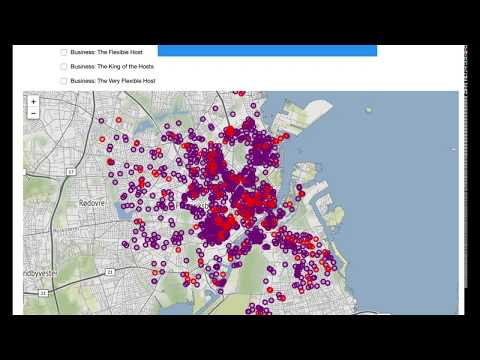

In [57]:
from IPython.display import YouTubeVideo
YouTubeVideo("uBS5-i_Cx0w",width=800, height=450)

# 7. Contributions. Who did what?   

Below is an overview of the head responsible for each section. All group members were part of the brainstorming-, writing- and execution process.

The responsible for the Notebook: s180127 and s164519
- Motivation: s164519
- Basic stats: 
2.1 s180127
2.2 s180127 and s164519 
- Data Analysis 
3.1 s180127 
3.2 s180127 and s164519  
- Genre: s164519
- Visualizations: s164519 
- Discussion and future work: s180127 

Webpage responsible: s153631 
- Storyline: s153631 
- Movies: s153631 
- Layout: s153631
